# Bootstrap: A Simple Method to Estimate a Confidence Interval

The aim of this notebook is to show how to code a bootstrap estimate of an interval in Python. The bootstrap is introduced in topic 14.

The approach is very flexible as it can be applied in a uniform way to any statistic. The note book contains an example bootstrap function and three examples of its use.

**Contents**

 1. Section 0: A Simple Bootstrap Function
 1. Section 1: Mean of a distribution
 2. Section 2: Regression Coefficients
 3. Section 3: Difference between two Means


In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.utils import resample
import matplotlib.pyplot as plt
%matplotlib inline

## Section 0: Define a Simple Bootstrap Function

The following function uses the `sklearn.resample` to resample a dataframe, apply a function to the new dataframes and accumulate the results. 

In [2]:
# data - the sample; can be dataframe or an array
# cols - a list of column headings in the results dataframe
# repeats - the number of times the process is repeated
# func - the function that calculates the results for each sample: must return a value for each column

def bootstrapC(data, cols, repeats, func):
    result = pd.DataFrame(data = dict([(c, np.empty(repeats)) for c in cols]))
    
    for i in range(0, repeats):
        result.iloc[i] = func(resample(data)) # default is to resample, same size
    return result

## Section 1: Mean of a Distribution
This section looks at the simplest problem, to estimate the CI on a mean.

### Section 1.1: Generate Some Sample Data
Generate a sample of 200 data points from a normal.

In [3]:
Z = 200

df = pd.DataFrame(data={'value': stats.norm.rvs(loc = 0.7, scale = 1.7, size=Z)})
df

,value
0,-1.171978
1,2.333735
2,-0.355321
3,0.634690
4,-1.375334
...,...
195,2.345021
196,1.955933
197,2.606151
198,-1.273686


In [4]:
df.mean()

value    0.717598
dtype: float64

## Section 1.1 Using Bootstrap to Estimate a CI on the mean

To use the bootstrap function, we need to define a suitable function to be applied to the resampled dataframes. It is convenient to plot the results as a histogram.

array([[<AxesSubplot:title={'center':'Mean'}>]], dtype=object)

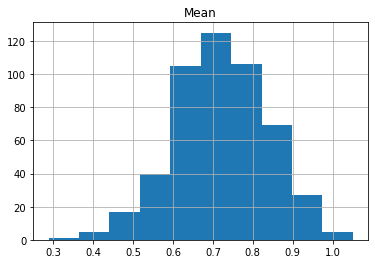

In [5]:
def df_mean(df):
    return [df.mean()]
    
result = bootstrapC(df.value, ['Mean'], 500, df_mean) 
result.hist()

The CI is given by the quantiles of the result data.

In [6]:
print('90%% range is %4.3f to %4.3f' % 
      (result.Mean.quantile(0.05), result.Mean.quantile(0.95)))
print('95%% range is %4.3f to %4.3f' % 
      (result.Mean.quantile(0.025), result.Mean.quantile(0.975)))

90% range is 0.528 to 0.907
95% range is 0.483 to 0.937


### Section 1.2 Comparison with the Student-t Interval
We can also estimate the CI using the Student t distribution. The results are quite close. 

In [7]:
lower1, upper1 = stats.t.interval(0.90, len(df)-1, loc=df.mean(), scale=df.std() / np.sqrt(len(df)))
print('90%% confidence interval for mean is %4.3f to %4.3f' % (lower1[0], upper1[0]))

lower2, upper2 = stats.t.interval(0.95, len(df)-1, loc=df.mean(), scale=df.std() / np.sqrt(len(df)))
print('95%% confidence interval for mean is %4.3f to %4.3f' % (lower2[0], upper2[0]))

90% confidence interval for mean is 0.516 to 0.919
95% confidence interval for mean is 0.478 to 0.958


## Section 2: Regression
We use the example based on the Heart data (see regression notebook)


### Section 2.1 Loading the Heart Data

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# types and type dictionary
sex_t = pd.CategoricalDtype(categories=['M','F'], ordered=False)
pain_t = pd.CategoricalDtype(categories=['Typical','Atypical','Non_anginal','Asymptomatic'], ordered=False)
ECG_t = pd.CategoricalDtype(categories=['Normal','ST-T wave','Hypertrophy'], ordered=False)
ECG_ST_t = pd.CategoricalDtype(categories=['Upsloping', 'Flat', 'Downsloping'], ordered=False)
Thal_t = pd.CategoricalDtype(categories=['Normal','Fixed','Reversible'], ordered=False)
types_dict = {'Sex':sex_t, 'ChestPain':pain_t, 'RestECG': ECG_t, 'ECG_ST_slope': ECG_ST_t, 'Thallium':Thal_t}

hearts = pd.read_csv('heart_cleveland_recoded.csv', dtype = types_dict)

### Section 2.2 Use the Bootstrap Function and Calculate CIs
To do this, the regression calculation must be made into a function. We choose to return four values.  

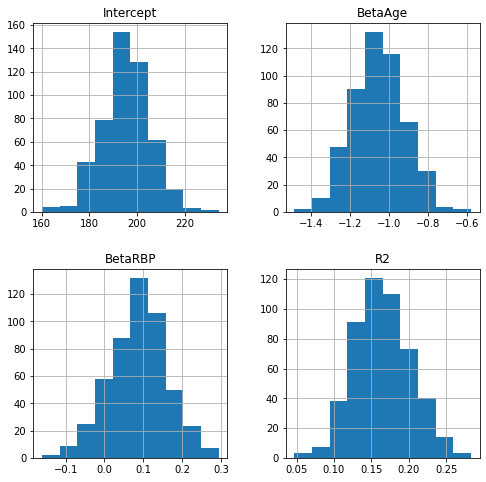

In [9]:
def doRegression(df) :
    y = df.MaxRate # this is the target variable; we assue just one though more are possible
    X = np.column_stack((df.Age,df.RestBP))
    reg = LinearRegression().fit(X, y)
    beta_Age, beta_RestBP = reg.coef_
    return [reg.intercept_, beta_Age, beta_RestBP, reg.score(X, y)] 

bstrap = bootstrapC(hearts, ['Intercept', 'BetaAge', 'BetaRBP', 'R2'], 500, doRegression) 
_ = bstrap.hist(figsize=(8,8))

We again use the quantile function to estimate the CIs.

In [10]:
intercept, betaAge, betaRP, r2 = doRegression(hearts)

print("Intercept is %4.1f, with 90%% CI from %4.1f to %4.1f" % 
      (intercept, bstrap.Intercept.quantile(0.05), bstrap.Intercept.quantile(0.95)))

print("Age coefficient is %3.2f, with 90%% CI from %3.2f to %3.2f" % 
      (betaAge, bstrap.BetaAge.quantile(0.05), bstrap.BetaAge.quantile(0.95)))

print("The R2 coefficient of determination is %3.2f, with 90%% CI from %3.2f to %3.2f" % 
      (r2, bstrap.R2.quantile(0.05), bstrap.R2.quantile(0.95)))

Intercept is 194.9, with 90% CI from 178.7 to 211.7
Age coefficient is -1.05, with 90% CI from -1.28 to -0.82
The R2 coefficient of determination is 0.16, with 90% CI from 0.11 to 0.23


## Section 3: Difference Between Two Means
We calculate a confidence interval on the difference between 2 means.

### Section 3.1 Using the Bootstrap
We use the `group_by` function to separate those with and without disease and calculate the difference between the means of cholesterol value for the two groups

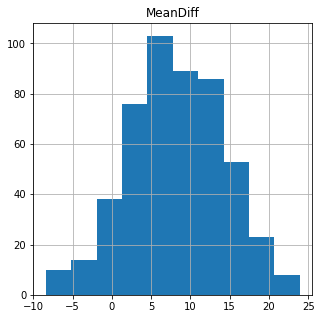

In [11]:
def cholMean(df): 
    gby_disease = df.groupby(by = 'Disease')
    mean_disease = gby_disease.get_group(True).Chol.mean()
    mean_well = gby_disease.get_group(False).Chol.mean()
    return [mean_disease - mean_well]

bstrap = bootstrapC(hearts, ['MeanDiff'], 500, cholMean) 
_ = bstrap.hist(figsize=(5,5))

### Section 3.2 Estimate the CIs
As before, the CIs are estimated using the quantiles of the bootstrap distribution.

In [12]:
sampleDiff = cholMean(hearts)[0]
print("The difference between the mean cholesterol (disease - no disease) is %3.2f with 80%% CI %3.2f to %3.2f" % 
      (sampleDiff, bstrap.MeanDiff.quantile(0.1), bstrap.MeanDiff.quantile(0.9)))
print("The difference between the mean cholesterol (disease - no disease) is %3.2f with 90%% CI %3.2f to %3.2f" % 
      (sampleDiff, bstrap.MeanDiff.quantile(0.05), bstrap.MeanDiff.quantile(0.95)))
print("The difference between the mean cholesterol (disease - no disease) is %3.2f with 99%% CI %3.2f to %3.2f" % 
      (sampleDiff, bstrap.MeanDiff.quantile(0.005), bstrap.MeanDiff.quantile(0.995)))

The difference between the mean cholesterol (disease - no disease) is 8.36 with 80% CI 0.48 to 15.94
The difference between the mean cholesterol (disease - no disease) is 8.36 with 90% CI -1.82 to 17.92
The difference between the mean cholesterol (disease - no disease) is 8.36 with 99% CI -6.93 to 23.18


### Section 3.3 Compare with Result of Welch's t-Test

We can calculate the p-value returned using the t-test. We see that at 90% the hypothesis that the means are the same is rejected but not at 99%. This conclusion depends on whether the bootstrap CI for the difference includes zero. The 99% bootstrap CI consistently includes zero difference; however, the results of the bootstrap vary and the 90% confidence interval often includes zero.

In [13]:
hrts_by_d = hearts.groupby(by = 'Disease')
mean_disease = hrts_by_d.get_group(True).Chol.mean()
mean_well = hrts_by_d.get_group(False).Chol.mean()

res = stats.ttest_ind(hrts_by_d.get_group(True).Chol, hrts_by_d.get_group(False).Chol, equal_var=False )
print('Compare cholesterol with heart disease (mean %3.2F) and without (mean %3.2F): p-value for a one tail test = %5.4f' % 
      (mean_disease, mean_well, res.pvalue / 2))

Compare cholesterol with heart disease (mean 251.85) and without (mean 243.49): p-value for a one tail test = 0.0825
